# <span style="color:blue"> Sign language digit recognition (ResNet) </span>

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform
from tensorflow.keras.models import Model
tfl = tf.keras.layers

In [4]:
loc = './data/'
print(f"load train data:")
train_hdf = h5py.File(loc+'signs_train.h5', 'r')
print(f"list of keys in train dataset: {list(train_hdf.keys())}")
X_train = np.array(train_hdf.get('train_set_x'))/255
y_train = np.array(train_hdf.get('train_set_y'))
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")

print(f"load test data:")
test_hdf = h5py.File(loc+'signs_test.h5', 'r')
print(f"list of keys in test dataset: {list(test_hdf.keys())}")
X_test = np.array(test_hdf.get('test_set_x'))/255
y_test = np.array(test_hdf.get('test_set_y'))
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

load train data:
list of keys in train dataset: ['list_classes', 'train_set_x', 'train_set_y']
X_train.shape = (1080, 64, 64, 3)
y_train.shape = (1080,)
load test data:
list of keys in test dataset: ['list_classes', 'test_set_x', 'test_set_y']
X_test.shape = (120, 64, 64, 3)
y_test.shape = (120,)


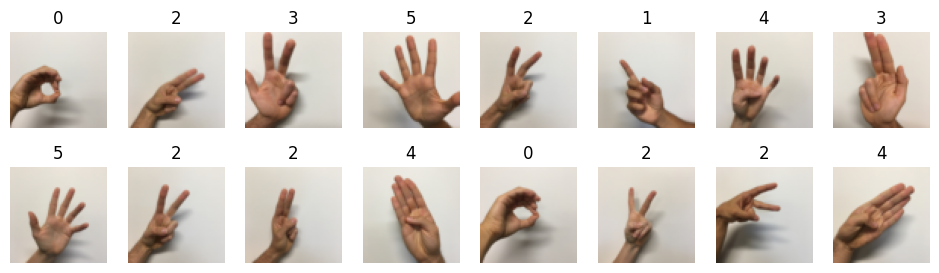

In [5]:
m = X_train.shape[0]
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(12, 3))
fig.subplots_adjust(wspace=0.1, hspace=0.4)
for a in ax.flat:
    random_index = np.random.randint(m)# pick a random training data
    a.imshow(X_train[random_index])
    a.set_title(y_train[random_index])
    a.set_axis_off()

plt.show()

# ResNet blocks

## Identity block
Identity block is constructed assuming that the input and output activations have the same dimensions. We use three hidden layers in each block, so, $a^{[\ell]}$ and $a^{[\ell+2]}$ have the same dimensions, where $a$ and $\ell$ denote activation and layer index, respectively. We consider the following architecture for the identity block:

**Main path**
1. 
- Conv2D: $F_1$ $1\times 1$ filters with stride $1$ and valid padding
- BatchNormalization across the number of channels axis
- ReLU activation

2. 
- Conv2D: $F_2$ $f\times f$ filters with stride $1$ and same padding
- BatchNormalization across the number of channels axis
- ReLU activation

3. 
- Conv2D: $F_3$ $1\times 1$ filters with stride $1$ and valid padding
- BatchNormalization across the number of channels axis

**Add shortcut**
- Add(): $a^{[\ell]}+z^{[\ell+2]}$
- ReLU activation

In [6]:
def identity_block(X, f, nfilters, initializer=random_uniform):
    """
    Input:
    X: input activation shape = (m, n_H_prev, n_W_prev, n_C_prev)
    f: filter window for the middle conv layer; integer
    nfilters: number of filters for the hidden conv layers; list of integers
    training: True (default): Behave in training mode; False: Behave in inference mode
    initializer: to set up the initial weights of a layer. default = tensorflow.keras.initializers.random_uniform
    
    Output:
    X: outout activation
    """
    
    F1, F2, F3 = nfilters
    X_shortcut = X
    
    ### Main path
    # Stage 1
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    
    ### Add
    X = tfl.Add()([X,X_shortcut])
    X = tfl.Activation('relu')(X)

    return X

## Convolution block
Convolution block will be used when the input and output activations do not have the same dimensions. We simply convolve the input in the shortcut path to make the dimensions match.

**Main path**
1. 
- Conv2D: $F_1$ $1\times 1$ filters with stride $s$ and valid padding
- BatchNormalization across the number of channels axis
- ReLU activation

2. 
- Conv2D: $F_2$ $f\times f$ filters with stride $1$ and same padding
- BatchNormalization across the number of channels axis
- ReLU activation

3. 
- Conv2D: $F_3$ $1\times 1$ filters with stride $1$ and valid padding
- BatchNormalization across the number of channels axis

**Shortcut path**
- Conv2D: $F_3$ $1\times 1$ filters with stride $s$ and valid padding
- BatchNormalization across the number of channels axis

**Add shortcut**
- Add(): $a^{[\ell]}+z^{[\ell+2]}$
- ReLU activation

In [7]:
def convolutional_block(X, f, nfilters, s = 2, initializer=random_uniform):
    """
    Input:
    Input:
    X: input activation shape = (m, n_H_prev, n_W_prev, n_C_prev)
    f: filter window for the middle conv layer; integer
    nfilters: number of filters for the hidden conv layers; list of integers
    s: stride in the first conv of the main path and the shortcut block
    training: True (default): Behave in training mode; False: Behave in inference mode
    initializer: to set up the initial weights of a layer. default = tensorflow.keras.initializers.random_uniform
    
    Output:
    X: outout activation
    """
    
    F1, F2, F3 = nfilters
    X_shortcut = X

    ### Main path
    
    # Stage 1
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    X = tfl.Activation('relu')(X)

    # Stage 3
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    
    ### Shortcut path
    X_shortcut = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = -1)(X_shortcut, training=True)
    
    ### Add
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    
    return X

# Network
The details of the netwrok is provided below (inspired by the course):

1. 
Zero-padding pads the input with a pad of (3,3)

2. 
- Conv2D: $64$ $7\times 7$ filters with stride $2$ 
- BatchNormalization across the number of channels axis
- MaxPooling2D: $3\times 3$ window and a stride $2$
3. 
- Conv Block: $F=[64,64,256]$, filter $3\times 3$, $s=1$
- 2 Identity (ID) blocks: $F=[64,64,256]$, filter $3\times 3$
4. 
- Conv Block: $F=[128,128,512]$, filter $3\times 3$, $s=2$
- 3 Identity (ID) blocks: $F=[128,128,512]$, filter $3\times 3$
5. 
- Conv Block: $F=[256,256,1024]$, filter $3\times 3$, $s=2$
- 5 Identity (ID) blocks: $F=[256,256,1024]$, filter $3\times 3$
6. 
- Conv Block: $F=[512,512,2048]$, filter $3\times 3$, $s=2$
- 2 Identity (ID) blocks: $F=[512,512,2048]$, filter $3\times 3$
7. 
- AveragePooling2D: $2\times 2$ window
- Faltten()
- The Fully Connected (Dense) layer to softmax

In [8]:
def my_ResNet(input_shape = (64, 64, 3), nclasses = 6):
    X_input = tfl.Input(input_shape)

    X = tfl.ZeroPadding2D((3, 3))(X_input)
    
    X = tfl.Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = random_uniform(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=True)
    X = tfl.Activation('relu')(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = convolutional_block(X, 3, [64, 64, 256], 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, 3, [128, 128, 512], 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    X = convolutional_block(X, 3, [256, 256, 1024], 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, 3, [512, 512, 2048], 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = tfl.AveragePooling2D(pool_size=(2, 2))(X)
    X = tfl.Flatten()(X)
    X = tfl.Dense(units = nclasses, activation='softmax',name='output-layer',kernel_initializer = random_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X)

    return model

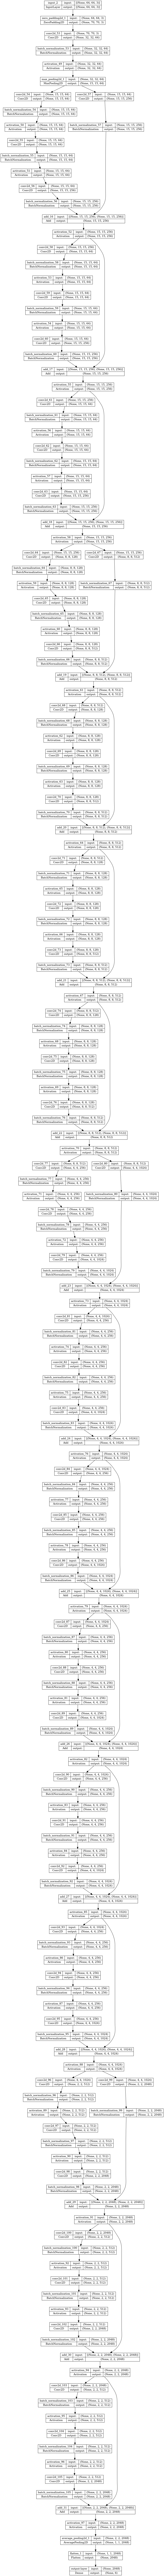

In [10]:
model = my_ResNet(input_shape = (64, 64, 3), nclasses = 6)
tf.keras.utils.plot_model(model, "ResNet-sign-language.png", show_shapes=True)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 32, 32, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_53 (BatchN  (None, 32, 32, 64)  256         ['conv2d_53[0][0]']        

                                                                                                  
 conv2d_63 (Conv2D)             (None, 15, 15, 256)  16640       ['activation_57[0][0]']          
                                                                                                  
 batch_normalization_63 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_63[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_18 (Add)                   (None, 15, 15, 256)  0           ['batch_normalization_63[0][0]', 
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 15, 15, 256)  0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 8, 8, 512)    0           ['batch_normalization_73[0][0]', 
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_67 (Activation)     (None, 8, 8, 512)    0           ['add_21[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 8, 8, 128)    65664       ['activation_67[0][0]']          
                                                                                                  
 batch_normalization_74 (BatchN  (None, 8, 8, 128)   512         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_84 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_77[0][0]']          
                                                                                                  
 batch_normalization_85 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
          

 activation_87 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_95 (Conv2D)             (None, 4, 4, 1024)   263168      ['activation_87[0][0]']          
                                                                                                  
 batch_normalization_95 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_95[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_28 (Add)                   (None, 4, 4, 1024)   0           ['batch_normalization_95[0][0]', 
                                                                  'activation_85[0][0]']          
                                                                                                  
 activatio

                                                                                                  
 add_31 (Add)                   (None, 2, 2, 2048)   0           ['batch_normalization_105[0][0]',
                                                                  'activation_94[0][0]']          
                                                                                                  
 activation_97 (Activation)     (None, 2, 2, 2048)   0           ['add_31[0][0]']                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 1, 1, 2048)  0           ['activation_97[0][0]']          
 oling2D)                                                                                         
                                                                                                  
 flatten_1 (Flatten)            (None, 2048)         0           ['average_pooling2d_1[0][0]']    
          

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
)

In [13]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
34/34 [==============================] - 31s 608ms/step - loss: 2.0882 - accuracy: 0.4528
Epoch 2/20
34/34 [==============================] - 21s 613ms/step - loss: 0.7244 - accuracy: 0.7481
Epoch 3/20
34/34 [==============================] - 21s 618ms/step - loss: 0.4238 - accuracy: 0.8611
Epoch 4/20
34/34 [==============================] - 22s 643ms/step - loss: 0.4822 - accuracy: 0.8435
Epoch 5/20
34/34 [==============================] - 21s 621ms/step - loss: 0.3420 - accuracy: 0.8926
Epoch 6/20
34/34 [==============================] - 20s 587ms/step - loss: 0.1358 - accuracy: 0.9546
Epoch 7/20
34/34 [==============================] - 20s 573ms/step - loss: 0.1328 - accuracy: 0.9500
Epoch 8/20
34/34 [==============================] - 19s 564ms/step - loss: 0.2147 - accuracy: 0.9296
Epoch 9/20
34/34 [==============================] - 19s 560ms/step - loss: 0.2683 - accuracy: 0.9120
Epoch 10/20
34/34 [==============================] - 19s 558ms/step - loss: 0.2185 - accura

# Model evaluation by test data

## model.evaluate()

In [16]:
eval = model.evaluate(X_test, y_test, verbose=0)
print(f"accuracy = {eval[1]*100:.2f}%")

accuracy = 95.00%


## model.predict()

In [23]:
number_data = m
predictions = model.predict(X_test[:number_data], verbose=0)
yhat = np.argmax(predictions, axis=1)
accuracy = np.mean(yhat == y_test[:number_data])
print(f"accuracy = {accuracy*100:.2f}%")

accuracy = 95.00%


## model()

In [24]:
model.trainable = False
m = X_test.shape[0]
yhat = []
for i in range(m):
    predictions = model(np.expand_dims(X_test[i], axis=0))
    yhat.append(np.argmax(predictions))
    
print(f"accuracy = {np.mean(yhat==y_test)*100:.2f}%")

accuracy = 96.67%


**Note** the values are slightly different because I set model.trainable to False. The layers are freezed.

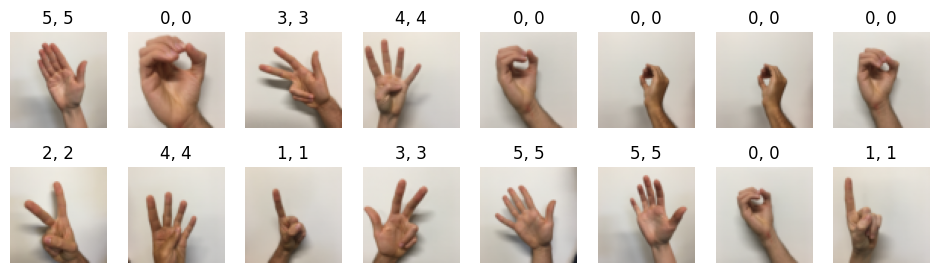

In [25]:
m = X_test.shape[0]
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(12, 3))
fig.subplots_adjust(wspace=0.1, hspace=0.4)
for a in ax.flat:
    random_index = np.random.randint(m)# pick a random test data
    a.imshow(X_test[random_index])
    a.set_title(f"{y_test[random_index]}, {yhat[random_index]}")
    a.set_axis_off()

plt.show()

# Testing the model with a new image
What if we need to predict a new case? The model fails if the image quality, color, lighting, etc. are dramatically different from those of the train cases. See an example below.

digit = 3


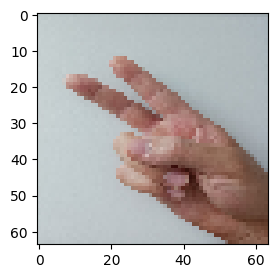

In [28]:
from tensorflow.keras.preprocessing import image
img_path = './data/sign-digit-image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
X_img = np.expand_dims(image.img_to_array(img), axis=0)/255
plt.figure(figsize=(3,3))
plt.imshow(img)
prediction = model(X_img)
print(f"digit = {np.argmax(prediction)}")